In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import numpy as np


import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses

from keras.layers import BatchNormalization

2022-11-09 18:30:36.539938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 18:30:38.813184: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jazhiel/Root/root/lib
2022-11-09 18:30:38.813256: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-09 18:30:39.111205: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-09 18:31:03.18

2.10.0


In [2]:
#hmf = pd.read_csv('/home/jazhiel/ML_Notebooks/Datasets/HMF_fit.csv')
#hmf = hmf.drop(['Unnamed: 0'], axis=1)
#dataset_1 = hmf.copy()
#dataset_1


hmf_new = pd.read_csv('/home/jazhiel/ML_Notebooks/Datasets/HMF_theor.csv')
hmf_new = hmf_new.drop(['Unnamed: 0'], axis=1)

dataset = hmf_new.copy()


x = dataset['log_10(mvir)'].values
y = dataset['n(>M)'].values



In [3]:
dataset

,log_10(mvir),n(>M)
0,1.000000e+10,2.543783e-01
1,1.122018e+10,2.298566e-01
2,1.258925e+10,2.077056e-01
3,1.412538e+10,1.876949e-01
4,1.584893e+10,1.696162e-01
...,...,...
95,5.623413e+14,1.997294e-06
96,6.309573e+14,1.556080e-06
97,7.079458e+14,1.199768e-06
98,7.943282e+14,9.146886e-07


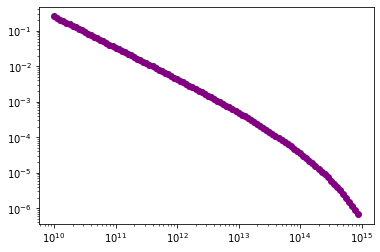

In [4]:
plt.yscale('log')
plt.xscale('log')

plt.scatter(hmf_new['log_10(mvir)'], hmf_new['n(>M)'], c = 'purple')

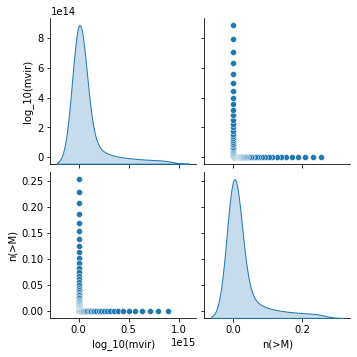

In [5]:
sns.pairplot(dataset, diag_kind="kde")

# plt.savefig("DistHD.png")



In [6]:
randomize = np.random.permutation(len(dataset.values))
data = dataset.values[randomize]

# Define a size for your train set 
split = 0.85
ntrain = int(split * len(data))
indx = [ntrain]
train_set, test_set = np.split(data, indx)

split = 0.5
ntrain = int(split * len(test_set))
indx = [ntrain]
validation_set, test_test = np.split(test_set, indx)

In [7]:




X_train = train_set[:, :-1]
y_train = train_set[:, -1]

X_val = validation_set[:, :-1]
y_val = validation_set[:, -1]

X_test = test_set[:, :-1]
y_test = test_set[:, -1]

In [8]:
print(X_test.shape)
print(y_test.shape)

(15, 1)
(15,)


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#xscaler = StandardScaler()
xscaler =   MinMaxScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
xscaler.fit(X_train)
# apply transform
X_train = xscaler.transform(X_train)
X_val = xscaler.transform(X_val)
X_test = xscaler.transform(X_test)

In [10]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=50.0,
                                   restore_best_weights=True)]

In [11]:
def ann_model(ninput=1, n_nodes1=100, n_nodes2=100, n_nodes3=100, dropout=0.5):
    model = models.Sequential()
    model.add(layers.Dense(n_nodes1,activation='relu', input_shape=(ninput,)))
    model.add(layers.Dropout(dropout))
    #model.add(BatchNormalization( momentum=0.1,
    #epsilon=0.01))
    model.add(layers.Dense(n_nodes2,activation='relu'))
    model.add(layers.Dropout(dropout))
    #model.add(BatchNormalization())
    model.add(layers.Dense(n_nodes3,activation='relu'))
    model.add(layers.Dropout(dropout))
    #model.add(BatchNormalization())
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer=optimizers.Adam(lr=1e-3),#RMSprop(lr=0.001),
                        loss='mae',
                        metrics=['mae', 'mse'])


#     test1_model.summary()
    return model

In [12]:
# dropout = grid_result.best_params_['dropout']
dropout = 0.4
# n_nodes1 = grid_result.best_params_['n_nodes1']
n_nodes1 = 200
# n_nodes2 = grid_result.best_params_['n_nodes2']
n_nodes2 = 200
# n_nodes3 = grid_result.best_params_['n_nodes3']
n_nodes3 = 200

In [13]:
neural_model = ann_model(n_nodes1=n_nodes1, n_nodes2=n_nodes2, n_nodes3=n_nodes3,
                        dropout=dropout)

estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                         patience=100, 
                                         restore_best_weights=True)

lrdecay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                               patience=2)
callbacks = [estop, lrdecay]

neural_model_history = neural_model.fit(X_train,
                                      y_train,
                                      epochs=300,
                                      batch_size=4,
                                      validation_data=(X_val,y_val),
                                      verbose=1)#, #callbacks=callbacks)



2022-11-09 18:31:26.982697: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jazhiel/Root/root/lib
2022-11-09 18:31:26.982755: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-09 18:31:26.982785: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Nitro-N5-Jazhiel): /proc/driver/nvidia/version does not exist
2022-11-09 18:31:26.983130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/jazhiel/anaconda3/envs/yt-env/lib/python3.10/site-pack

Epoch 1/300
22/22 [==============================] - 1s 10ms/step - loss: 0.0337 - mae: 0.0337 - mse: 0.0034 - val_loss: 0.0249 - val_mae: 0.0249 - val_mse: 0.0011
Epoch 2/300
22/22 [==============================] - 0s 3ms/step - loss: 0.0340 - mae: 0.0340 - mse: 0.0034 - val_loss: 0.0235 - val_mae: 0.0235 - val_mse: 0.0015
Epoch 3/300
22/22 [==============================] - 0s 3ms/step - loss: 0.0318 - mae: 0.0318 - mse: 0.0038 - val_loss: 0.0262 - val_mae: 0.0262 - val_mse: 0.0011
Epoch 4/300
22/22 [==============================] - 0s 3ms/step - loss: 0.0306 - mae: 0.0306 - mse: 0.0033 - val_loss: 0.0232 - val_mae: 0.0232 - val_mse: 0.0013
Epoch 5/300
22/22 [==============================] - 0s 3ms/step - loss: 0.0298 - mae: 0.0298 - mse: 0.0033 - val_loss: 0.0234 - val_mae: 0.0234 - val_mse: 0.0012
Epoch 6/300
22/22 [==============================] - 0s 3ms/step - loss: 0.0290 - mae: 0.0290 - mse: 0.0033 - val_loss: 0.0227 - val_mae: 0.0227 - val_mse: 0.0015
Epoch 7/300
22/22 [==

22/22 [==============================] - 0s 3ms/step - loss: 0.0248 - mae: 0.0248 - mse: 0.0030 - val_loss: 0.0203 - val_mae: 0.0203 - val_mse: 0.0014
Epoch 52/300
22/22 [==============================] - 0s 2ms/step - loss: 0.0245 - mae: 0.0245 - mse: 0.0031 - val_loss: 0.0222 - val_mae: 0.0222 - val_mse: 0.0012
Epoch 53/300
22/22 [==============================] - 0s 2ms/step - loss: 0.0247 - mae: 0.0247 - mse: 0.0030 - val_loss: 0.0209 - val_mae: 0.0209 - val_mse: 0.0013
Epoch 54/300
22/22 [==============================] - 0s 2ms/step - loss: 0.0245 - mae: 0.0245 - mse: 0.0031 - val_loss: 0.0204 - val_mae: 0.0204 - val_mse: 0.0014
Epoch 55/300
22/22 [==============================] - 0s 3ms/step - loss: 0.0256 - mae: 0.0256 - mse: 0.0033 - val_loss: 0.0207 - val_mae: 0.0207 - val_mse: 0.0015
Epoch 56/300
22/22 [==============================] - 0s 4ms/step - loss: 0.0253 - mae: 0.0253 - mse: 0.0033 - val_loss: 0.0206 - val_mae: 0.0206 - val_mse: 0.0015
Epoch 57/300
22/22 [=========

22/22 [==============================] - 0s 3ms/step - loss: 0.0256 - mae: 0.0256 - mse: 0.0034 - val_loss: 0.0210 - val_mae: 0.0210 - val_mse: 0.0015
Epoch 102/300
22/22 [==============================] - 0s 2ms/step - loss: 0.0254 - mae: 0.0254 - mse: 0.0032 - val_loss: 0.0206 - val_mae: 0.0206 - val_mse: 0.0015
Epoch 103/300
22/22 [==============================] - 0s 3ms/step - loss: 0.0248 - mae: 0.0248 - mse: 0.0033 - val_loss: 0.0201 - val_mae: 0.0201 - val_mse: 0.0014
Epoch 104/300
22/22 [==============================] - 0s 2ms/step - loss: 0.0244 - mae: 0.0244 - mse: 0.0031 - val_loss: 0.0201 - val_mae: 0.0201 - val_mse: 0.0014
Epoch 105/300
22/22 [==============================] - 0s 2ms/step - loss: 0.0249 - mae: 0.0249 - mse: 0.0031 - val_loss: 0.0204 - val_mae: 0.0204 - val_mse: 0.0013
Epoch 106/300
22/22 [==============================] - 0s 3ms/step - loss: 0.0250 - mae: 0.0250 - mse: 0.0031 - val_loss: 0.0214 - val_mae: 0.0214 - val_mse: 0.0012
Epoch 107/300
22/22 [===

Epoch 151/300
22/22 [==============================] - 0s 3ms/step - loss: 0.0246 - mae: 0.0246 - mse: 0.0031 - val_loss: 0.0197 - val_mae: 0.0197 - val_mse: 0.0013
Epoch 152/300
22/22 [==============================] - 0s 3ms/step - loss: 0.0245 - mae: 0.0245 - mse: 0.0031 - val_loss: 0.0199 - val_mae: 0.0199 - val_mse: 0.0013
Epoch 153/300
22/22 [==============================] - 0s 2ms/step - loss: 0.0248 - mae: 0.0248 - mse: 0.0032 - val_loss: 0.0194 - val_mae: 0.0194 - val_mse: 0.0014
Epoch 154/300
22/22 [==============================] - 0s 2ms/step - loss: 0.0249 - mae: 0.0249 - mse: 0.0031 - val_loss: 0.0194 - val_mae: 0.0194 - val_mse: 0.0013
Epoch 155/300
22/22 [==============================] - 0s 2ms/step - loss: 0.0246 - mae: 0.0246 - mse: 0.0033 - val_loss: 0.0199 - val_mae: 0.0199 - val_mse: 0.0013
Epoch 156/300
22/22 [==============================] - 0s 2ms/step - loss: 0.0243 - mae: 0.0243 - mse: 0.0031 - val_loss: 0.0199 - val_mae: 0.0199 - val_mse: 0.0012
Epoch 157/

22/22 [==============================] - 0s 2ms/step - loss: 0.0238 - mae: 0.0238 - mse: 0.0030 - val_loss: 0.0202 - val_mae: 0.0202 - val_mse: 0.0011
Epoch 201/300
22/22 [==============================] - 0s 3ms/step - loss: 0.0246 - mae: 0.0246 - mse: 0.0030 - val_loss: 0.0201 - val_mae: 0.0201 - val_mse: 0.0011
Epoch 202/300
22/22 [==============================] - 0s 3ms/step - loss: 0.0241 - mae: 0.0241 - mse: 0.0029 - val_loss: 0.0199 - val_mae: 0.0199 - val_mse: 0.0012
Epoch 203/300
22/22 [==============================] - 0s 2ms/step - loss: 0.0242 - mae: 0.0242 - mse: 0.0030 - val_loss: 0.0190 - val_mae: 0.0190 - val_mse: 0.0013
Epoch 204/300
22/22 [==============================] - 0s 2ms/step - loss: 0.0246 - mae: 0.0246 - mse: 0.0031 - val_loss: 0.0191 - val_mae: 0.0191 - val_mse: 0.0012
Epoch 205/300
22/22 [==============================] - 0s 3ms/step - loss: 0.0251 - mae: 0.0251 - mse: 0.0032 - val_loss: 0.0211 - val_mae: 0.0211 - val_mse: 0.0012
Epoch 206/300
22/22 [===

Epoch 250/300
22/22 [==============================] - 0s 2ms/step - loss: 0.0237 - mae: 0.0237 - mse: 0.0030 - val_loss: 0.0183 - val_mae: 0.0183 - val_mse: 0.0012
Epoch 251/300
22/22 [==============================] - 0s 2ms/step - loss: 0.0239 - mae: 0.0239 - mse: 0.0029 - val_loss: 0.0183 - val_mae: 0.0183 - val_mse: 0.0012
Epoch 252/300
22/22 [==============================] - 0s 3ms/step - loss: 0.0240 - mae: 0.0240 - mse: 0.0031 - val_loss: 0.0186 - val_mae: 0.0186 - val_mse: 0.0013
Epoch 253/300
22/22 [==============================] - 0s 2ms/step - loss: 0.0237 - mae: 0.0237 - mse: 0.0030 - val_loss: 0.0185 - val_mae: 0.0185 - val_mse: 0.0012
Epoch 254/300
22/22 [==============================] - 0s 2ms/step - loss: 0.0243 - mae: 0.0243 - mse: 0.0032 - val_loss: 0.0187 - val_mae: 0.0187 - val_mse: 0.0011
Epoch 255/300
22/22 [==============================] - 0s 3ms/step - loss: 0.0234 - mae: 0.0234 - mse: 0.0028 - val_loss: 0.0184 - val_mae: 0.0184 - val_mse: 0.0012
Epoch 256/

22/22 [==============================] - 0s 2ms/step - loss: 0.0241 - mae: 0.0241 - mse: 0.0030 - val_loss: 0.0184 - val_mae: 0.0184 - val_mse: 0.0010
Epoch 300/300
22/22 [==============================] - 0s 3ms/step - loss: 0.0255 - mae: 0.0255 - mse: 0.0030 - val_loss: 0.0188 - val_mae: 0.0188 - val_mse: 0.0013


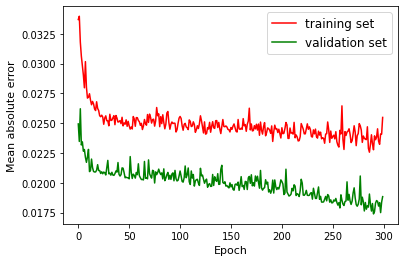

In [14]:
plt.plot(neural_model_history.history['mae'], color='r', )
plt.plot(neural_model_history.history['val_mae'], color='g')


plt.ylabel('Mean absolute error', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)


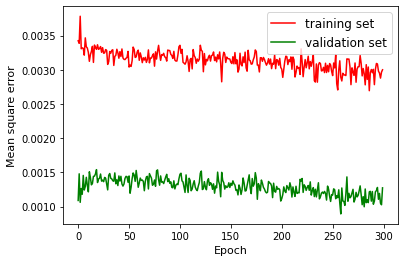

In [15]:
plt.plot(neural_model_history.history['mse'], color='r', )
plt.plot(neural_model_history.history['val_mse'], color='g')


plt.ylabel('Mean square error', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)


In [16]:
ypred2 = neural_model.predict(X_test)
#####
print('Traning and Testing on raw data, all features \n');
#### Model accuracy

# print("Accuracy:", metrics.accuracy_score(y_test, ypred2))

1/1 [==============================] - 0s 73ms/step
Traning and Testing on raw data, all features 



In [17]:

x_test_or = xscaler.inverse_transform(X_test)
# yor = scalery.inverse_transform(y)


In [18]:
x_test_sort = np.sort(x_test_or.T, axis = 1)
x_test_sort.T

array([[1.25892541e+10],
       [3.16227766e+10],
       [5.62341325e+10],
       [6.30957344e+10],
       [1.25892541e+11],
       [7.94328235e+11],
       [1.58489319e+12],
       [1.12201845e+13],
       [1.41253754e+13],
       [3.98107171e+13],
       [5.01187234e+13],
       [5.62341325e+13],
       [6.30957344e+13],
       [3.54813389e+14],
       [6.30957344e+14]])

In [19]:
lcdm = pd.read_csv('/home/jazhiel/ML_Notebooks/YT_ensayo/Rockstar/LCDM/lcdm_counts.dat')
#lcdm = pd.read_csv('/home/jazhiel/Escritorio/YT_ensayo/Rockstar/LCDM/lcdm_counts.dat')
#df.drop(['B', 'C'], axis=1)
lcdm = lcdm.drop(['Unnamed: 0'], axis = 1)
lcdm

,log_10(M200c),counts,n(>M)
0,10.572196,773,0.028888
1,10.877562,717,0.022704
2,11.182927,689,0.016968
3,11.488293,625,0.011456
4,11.793659,372,0.006456
5,12.099025,221,0.003480
6,12.404391,107,0.001712
7,12.709756,46,0.000856
8,13.015122,35,0.000488
9,13.320488,12,0.000208


In [20]:
ypred2_sort = -np.sort(-ypred2.T, axis = -1)
ypred2_sort.T

array([[ 0.00807605],
       [ 0.00805703],
       [ 0.00803244],
       [ 0.00802558],
       [ 0.00796284],
       [ 0.00729498],
       [ 0.0065044 ],
       [-0.00030825],
       [-0.00060515],
       [-0.00071008],
       [-0.00071008],
       [-0.00071008],
       [-0.00071008],
       [-0.00071008],
       [-0.00071008]], dtype=float32)

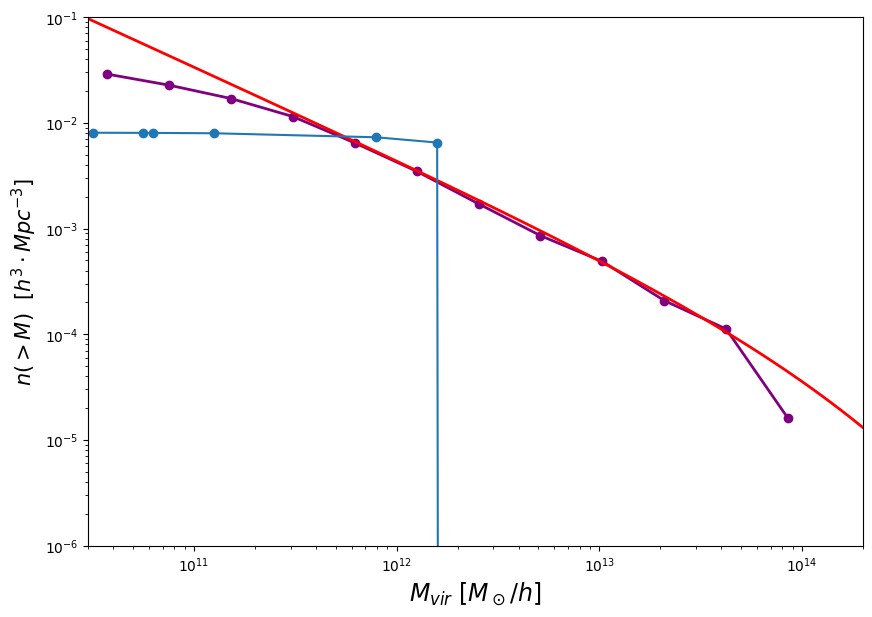

In [21]:


plt.figure(figsize=(10, 7), dpi=100)

plt.yscale('log')
plt.xscale('log')

plt.scatter(10**lcdm['log_10(M200c)'], lcdm['n(>M)'], c = 'purple')
#plt.plot(10**lcdm['log_10(M200c)'], lcdm['n(>M)'], c = 'purple', linestyle = '--', linewidth = 2, label = '$\Lambda$CDM simulation')
plt.plot(10**lcdm['log_10(M200c)'], lcdm['n(>M)'], c = 'purple', linewidth=2, label='$\Lambda$CDM simulation')


#planck = np.loadtxt('/home/jazhiel/ML_Notebooks/YT_ensayo/Rockstar/LCDM/all_plots/mVector_PLANCK-SMT .txt')
#plt.plot(planck[:,0], planck[:,8], 'g', label='Tinker (2008)', linewidth=2)

profile = np.loadtxt('/home/jazhiel/ML_Notebooks/YT_ensayo/Rockstar/LCDM/all_plots/mVector_SIMULATION .txt')
plt.plot(profile[:,0],profile[:,8],'r',label='Press-Schechter (1974) ',linewidth=2)
#plt.legend(loc=0, prop={'size': 14})

plt.scatter(x_test_sort.T,ypred2_sort.T)
plt.plot(x_test_sort.T,ypred2_sort.T)
#plt.scatter(x_test_sort.T,ypred2_sort.T[:,1])
#plt.plot(x_test_sort.T,ypred2_sort.T[:,1])
#plt.scatter(x_test_sort.T,ypred2_sort.T[:,2])
#plt.plot(x_test_sort.T,ypred2_sort.T[:,2])
#plt.scatter(x_test_sort.T,ypred2_sort.T[:,3])
#plt.plot(x_test_sort.T,ypred2_sort.T[:,3])
#plt.scatter(x_test_sort.T,ypred2_sort.T[:,4])
#plt.plot(x_test_sort.T,ypred2_sort.T[:,4])


plt.xlabel('$M_{vir}$ $[M_\odot/h]$',fontsize=17)
plt.ylabel('$n(>M)$  $[h^3 \cdot Mpc^{-3}]$',fontsize=15)

plt.xlim([3.e10,2.e14])
plt.ylim([1.e-6,1.e-1])
#plt.savefig('/home/jazhiel/Escritorio/Maestria/Machine_Learning/IMG_Tesis/HMF_SFDM_extended.png')
plt.show()

In [22]:
x_test_sort.shape

(1, 15)

In [23]:
ypred2_sort.shape

(1, 15)